In [1]:
import argparse
from diffusion_1d import Unet1D, GaussianDiffusion1D, Trainer1D, num_to_groups,TemporalUnet1D,Unet1D_forward_model,linear_beta_schedule
from filepath import EXP_PATH
import matplotlib.pylab as plt
import matplotlib.backends.backend_pdf
from nbody_dataset import NBodyDataset
import numpy as np
import pdb
import torch
from torch_geometric.data.dataloader import DataLoader
from utils import p, get_item_1d, COLOR_LIST,CustomSampler,simulation,eval_simu,caculate_confidence_interval,cosine_beta_schedule
from torch.autograd import grad

# In[ ]:
import argparse
import GNS_model
import torch.nn as nn
import os
import math


pygame 2.5.0 (SDL 2.28.0, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def get_eval_fn(pos_target, last_n_step, gamma=2):
    """pos: [B, steps, F], pos_target: [F]"""
    assert len(pos_target.shape) == 1
    def point_eval_objective(pos):
        n_bodies = pos.shape[-1] // 4
        loss = torch.stack([(((pos[...,-last_n_step:,jj*4:jj*4+2] - pos_target).abs() ** gamma).sum(-1) ** (1/gamma)).mean() for jj in range(n_bodies)]).mean()
        return loss.item()
    return point_eval_objective


def get_eval_fn_std(pos_target, last_n_step, gamma=2):
    """pos: [B, steps, F], pos_target: [F]"""
    assert len(pos_target.shape) == 1
    def point_eval_objective_std(pos):
        n_bodies = pos.shape[-1] // 4
        loss = torch.cat([(((pos[...,-last_n_step:,jj*4:jj*4+2] - pos_target).abs() ** gamma).sum(-1) ** (1/gamma)) for jj in range(n_bodies)], -1).mean(-1)
        loss_std = loss.std()
        return loss_std.item()
    return point_eval_objective_std

(50, 352)
[2023-11-18 03:30:09.147798] test_start    	383.699327s from last print, 1-step avg: 383.699327s


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM default


  0%|          | 0/50 [00:00<?, ?it/s]

[2023-11-18 03:32:28.218871] test_end    	139.071075s from last print, 1-step avg: 139.071075s
design_obj_simu: 0.331514 ± 0.045400
MAE: 0.2127478241847677 ± 0.028981293623554047


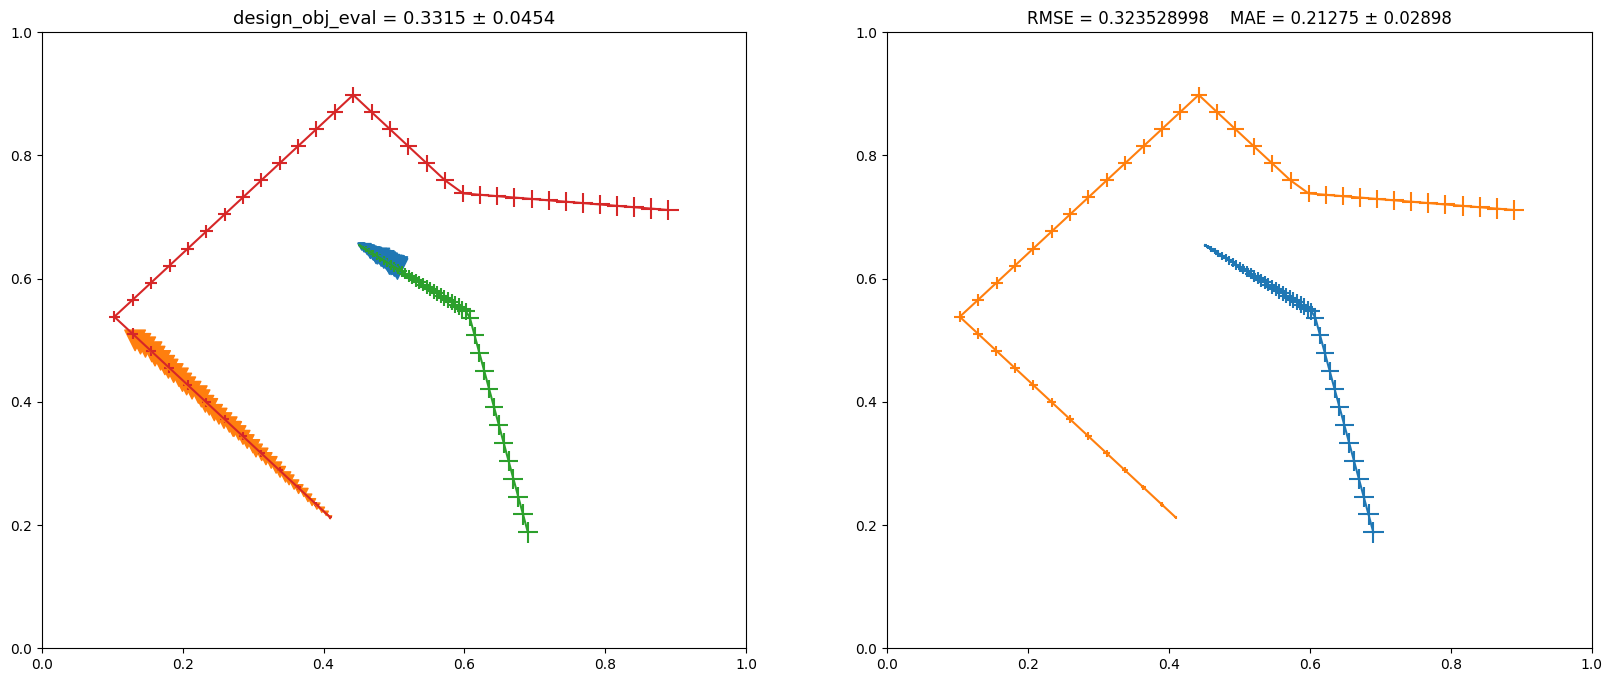

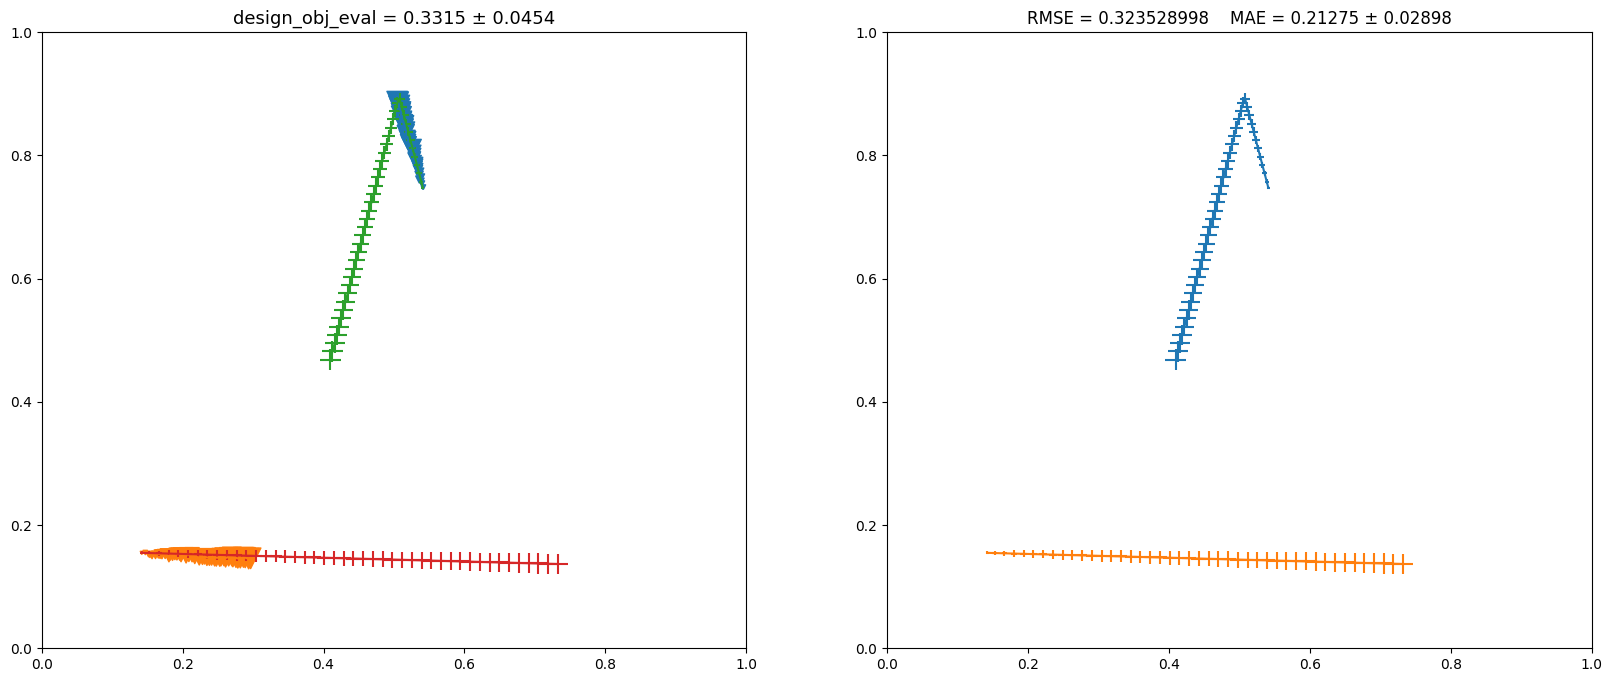

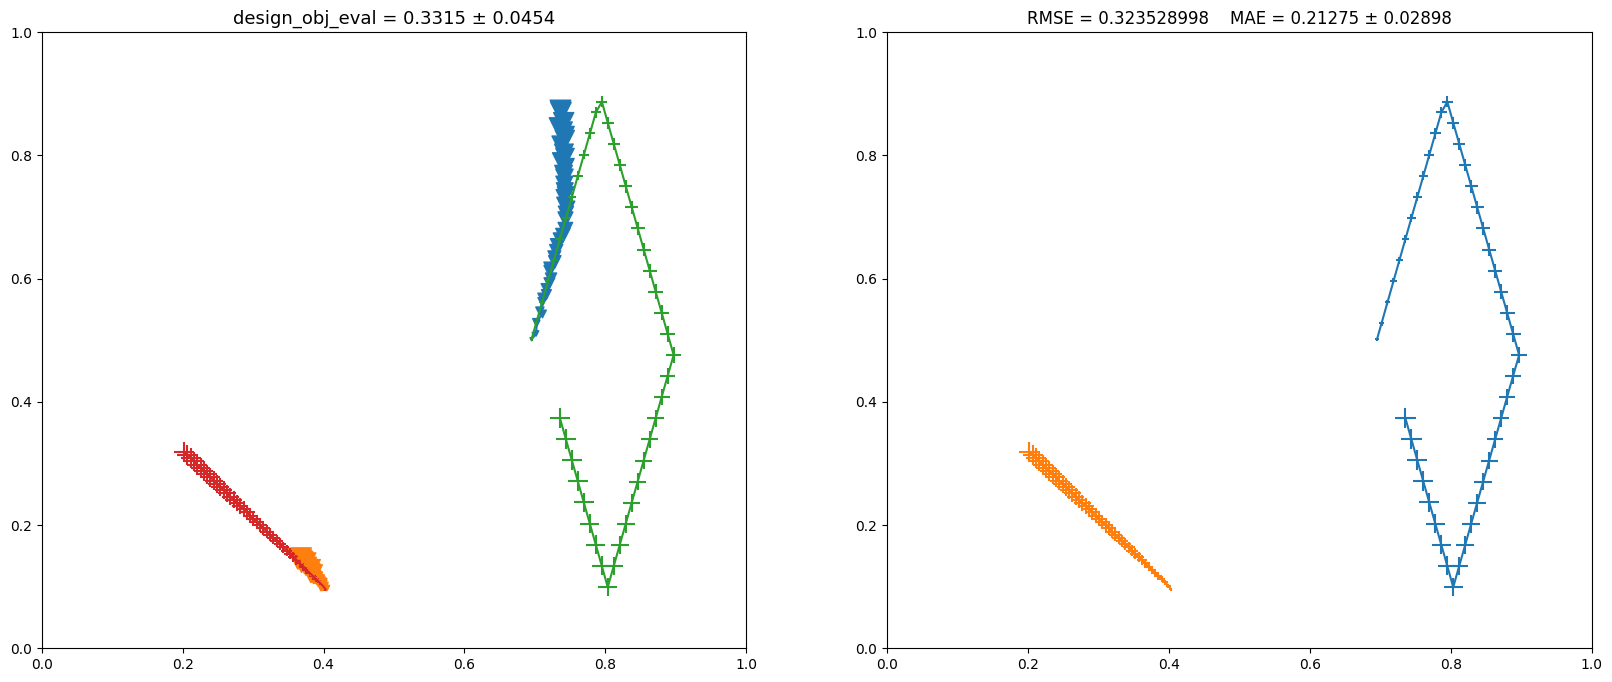

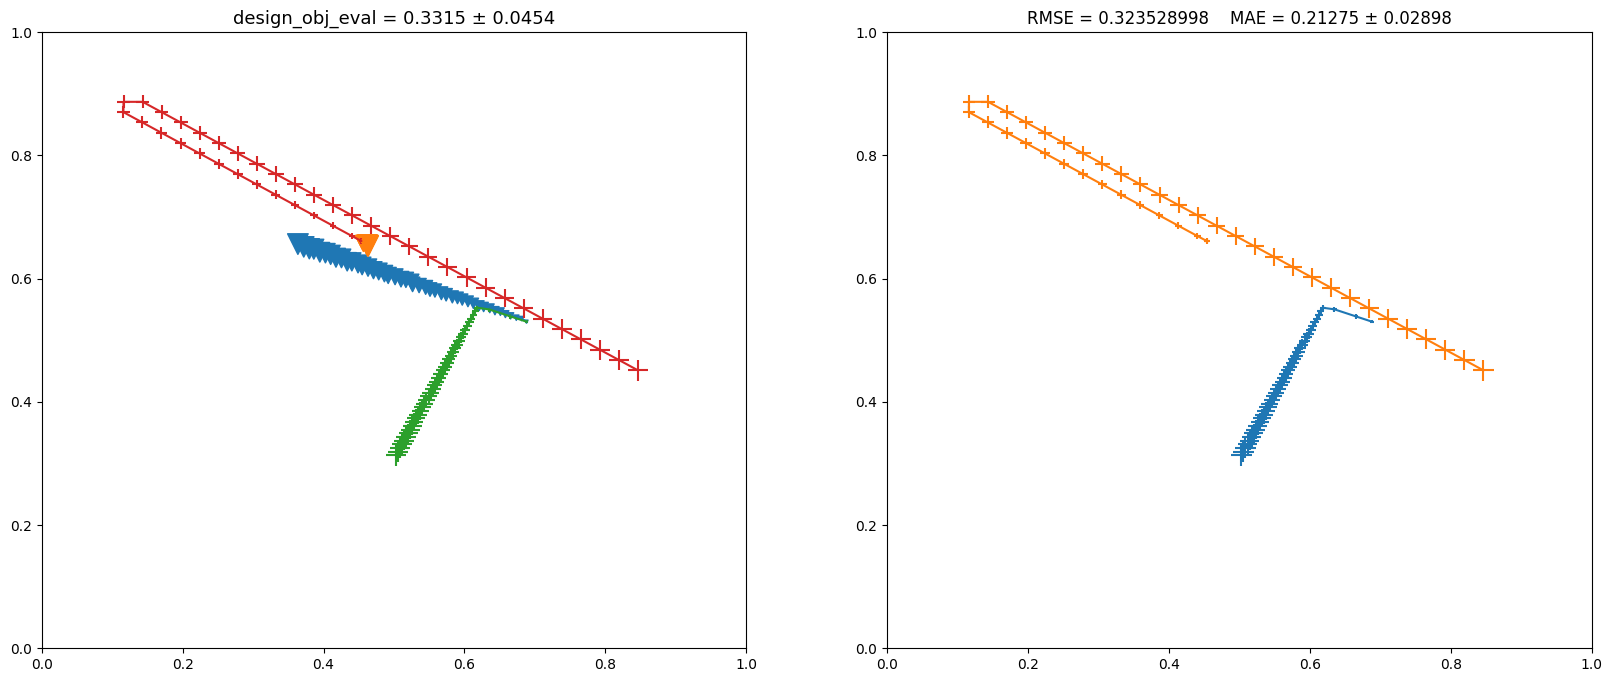

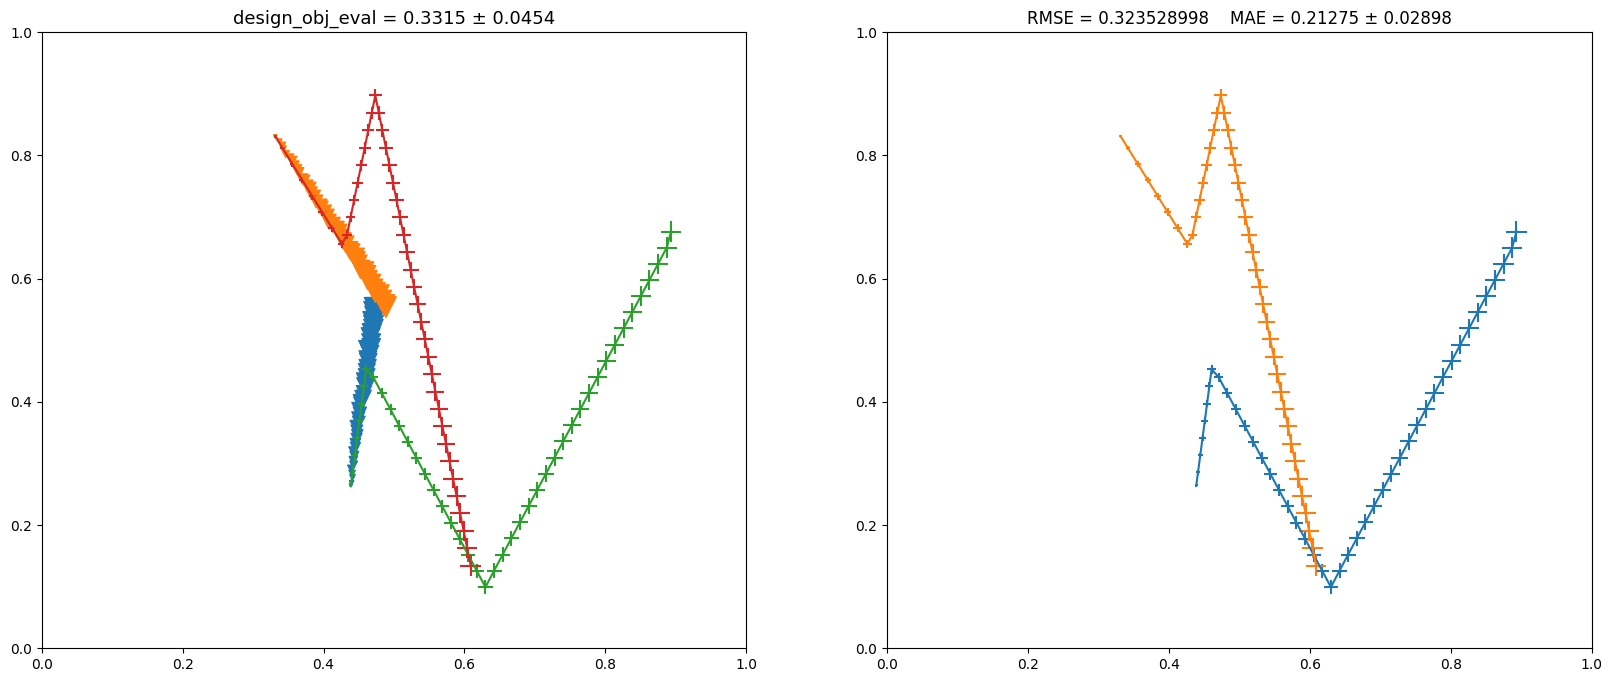

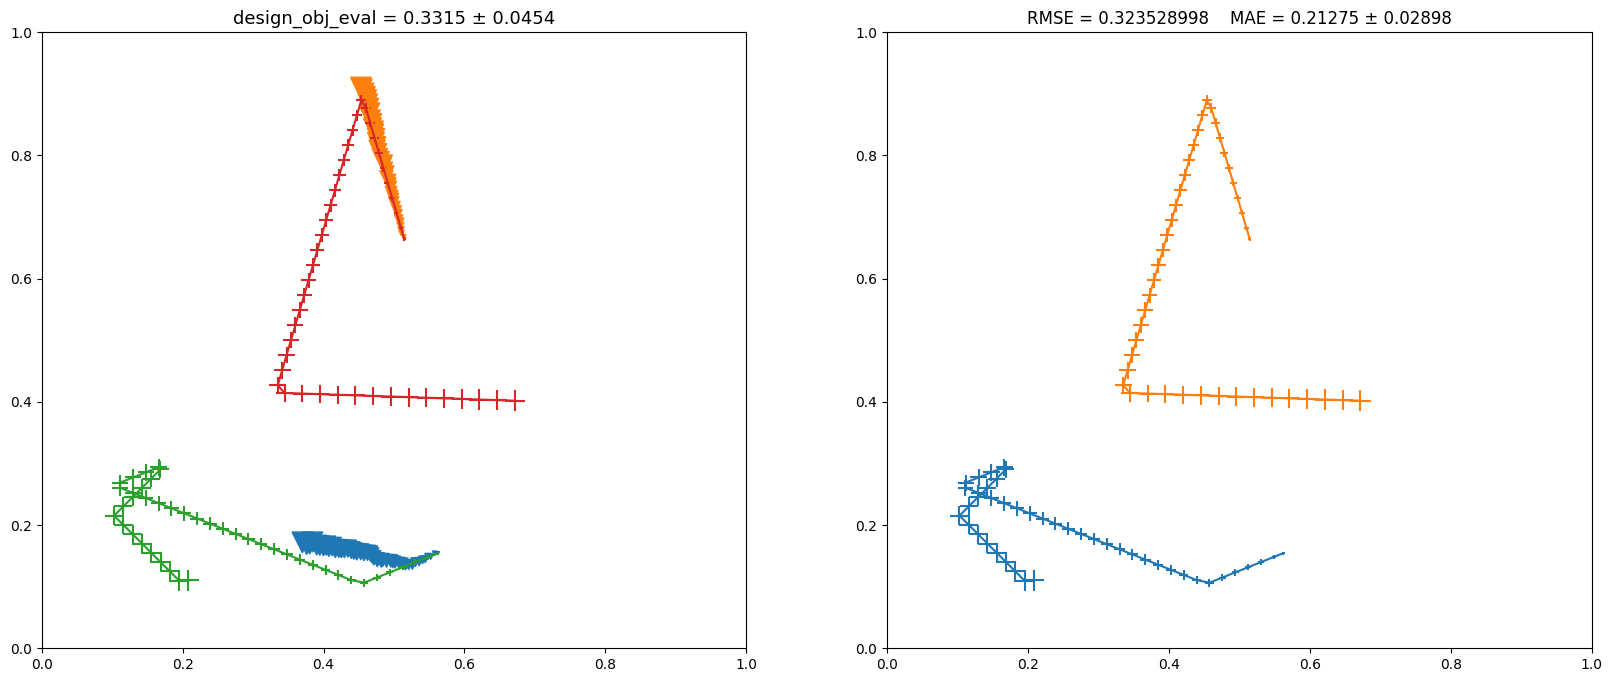

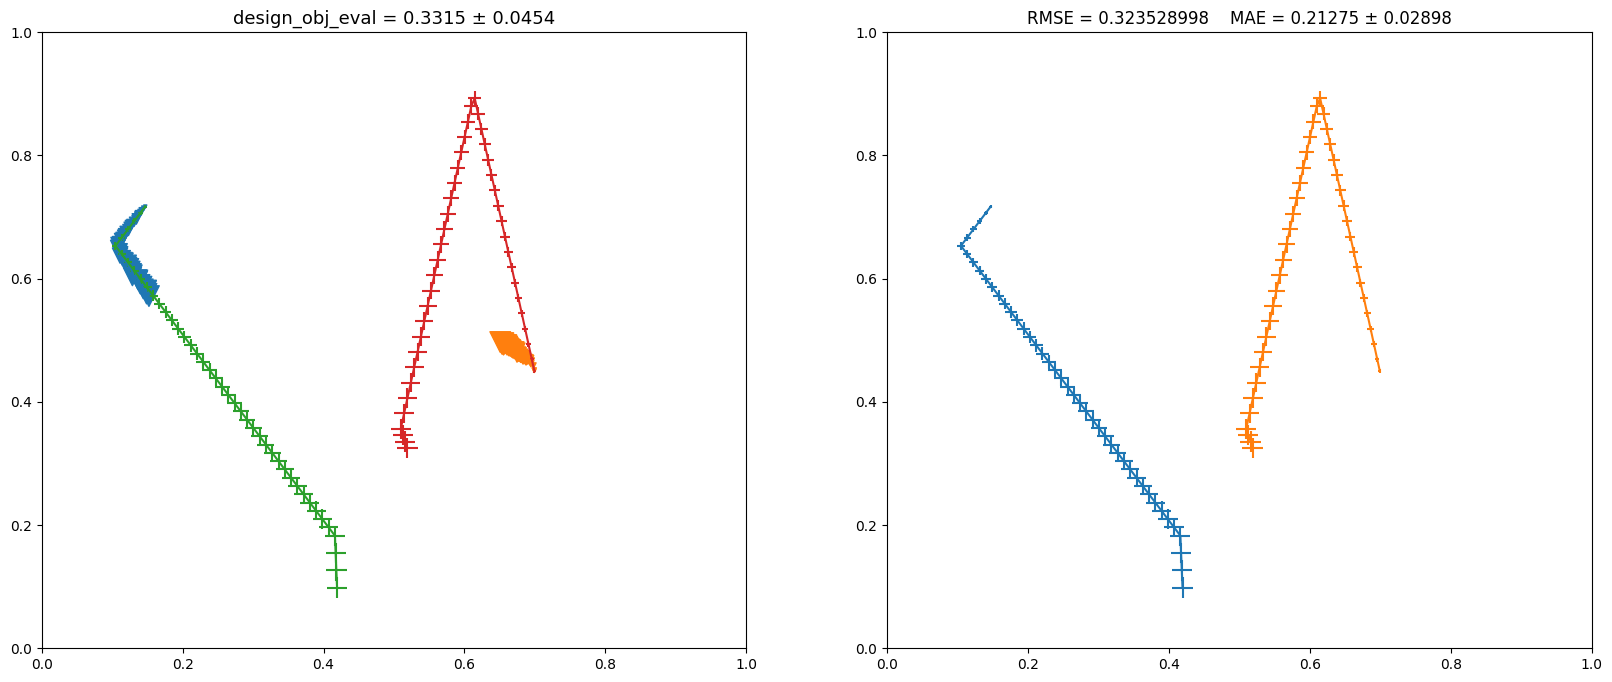

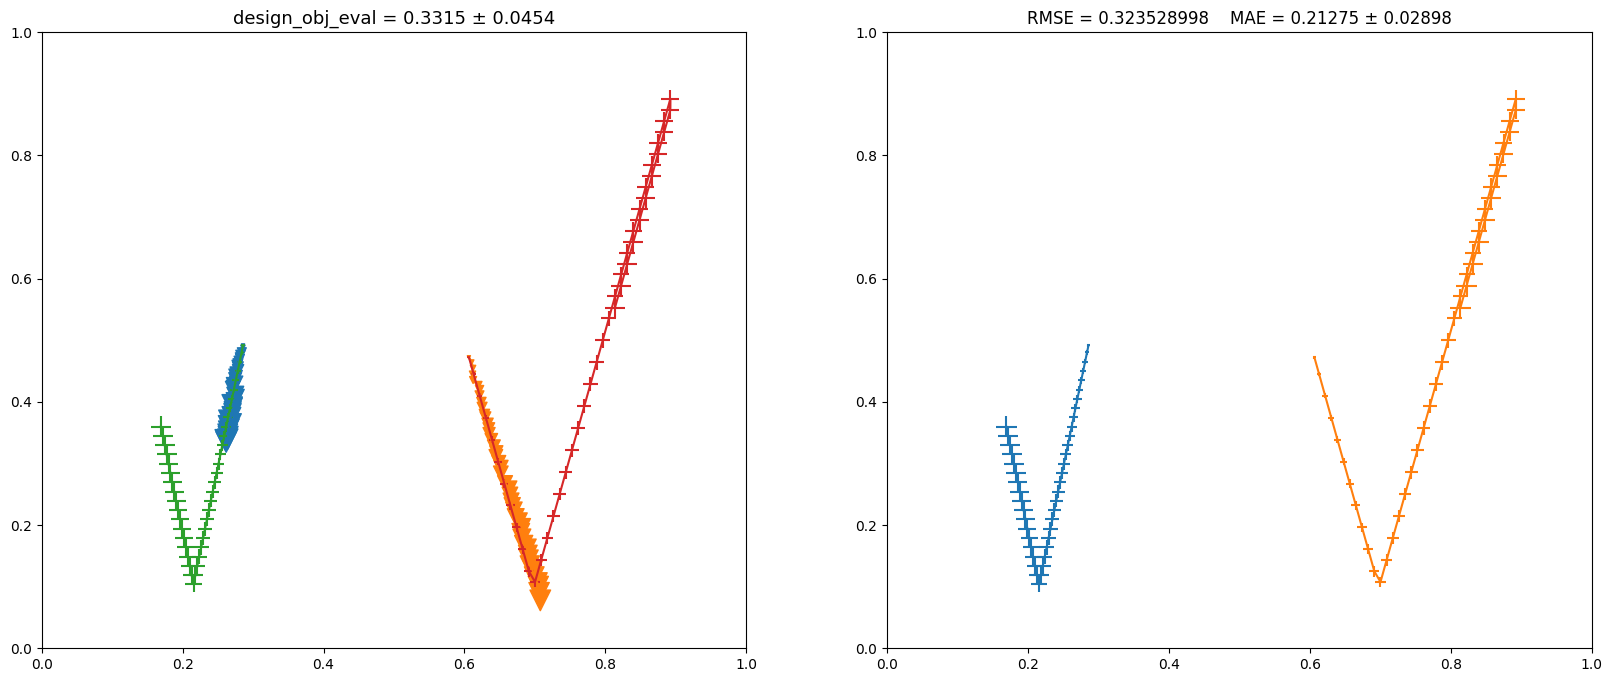

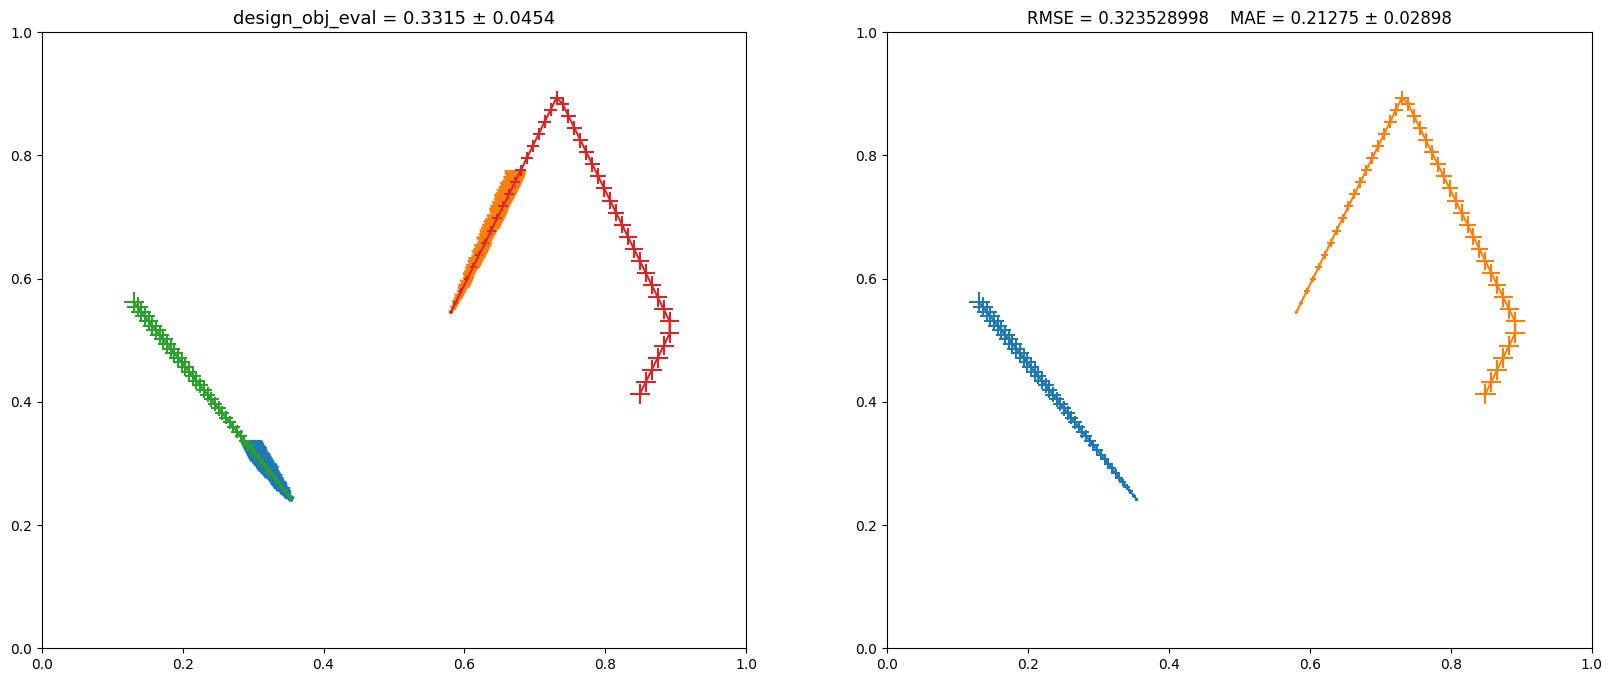

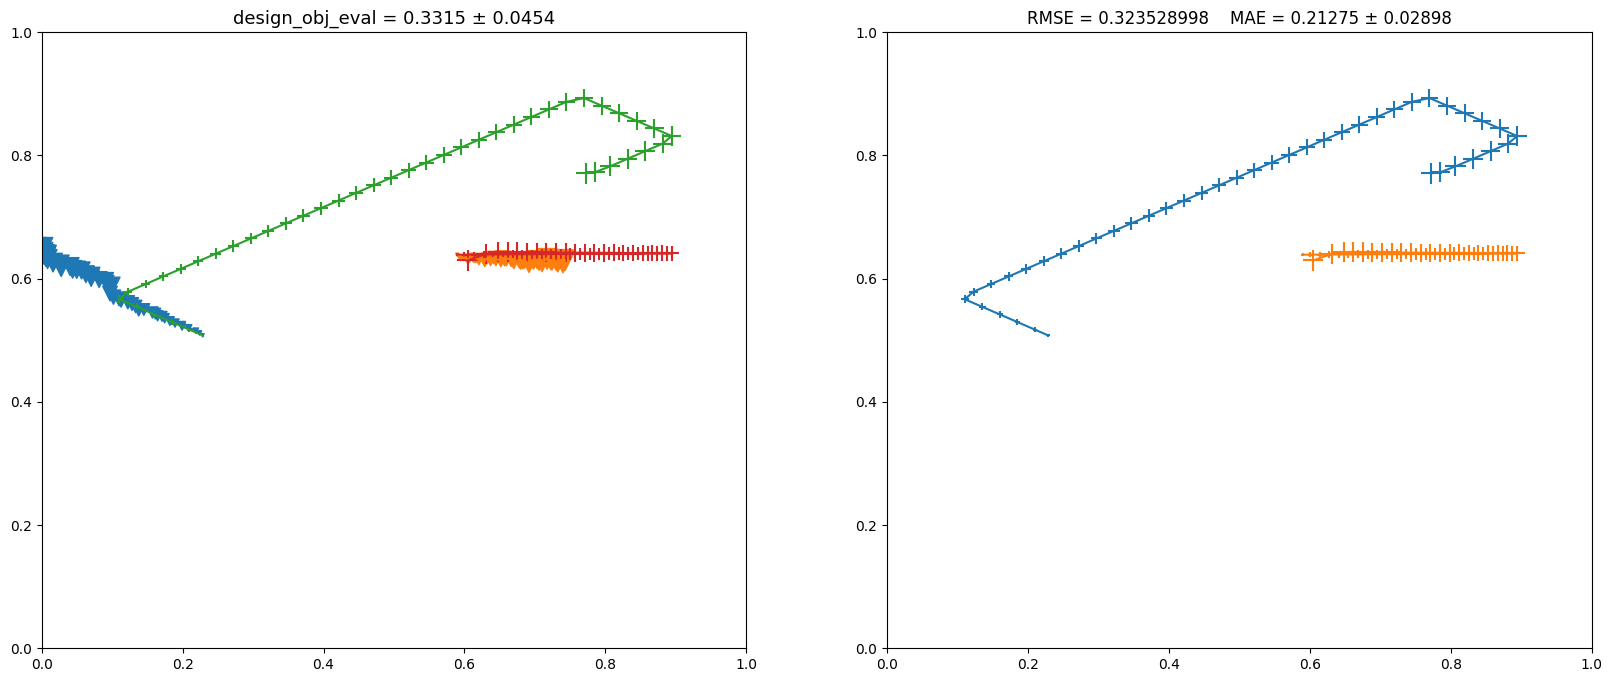

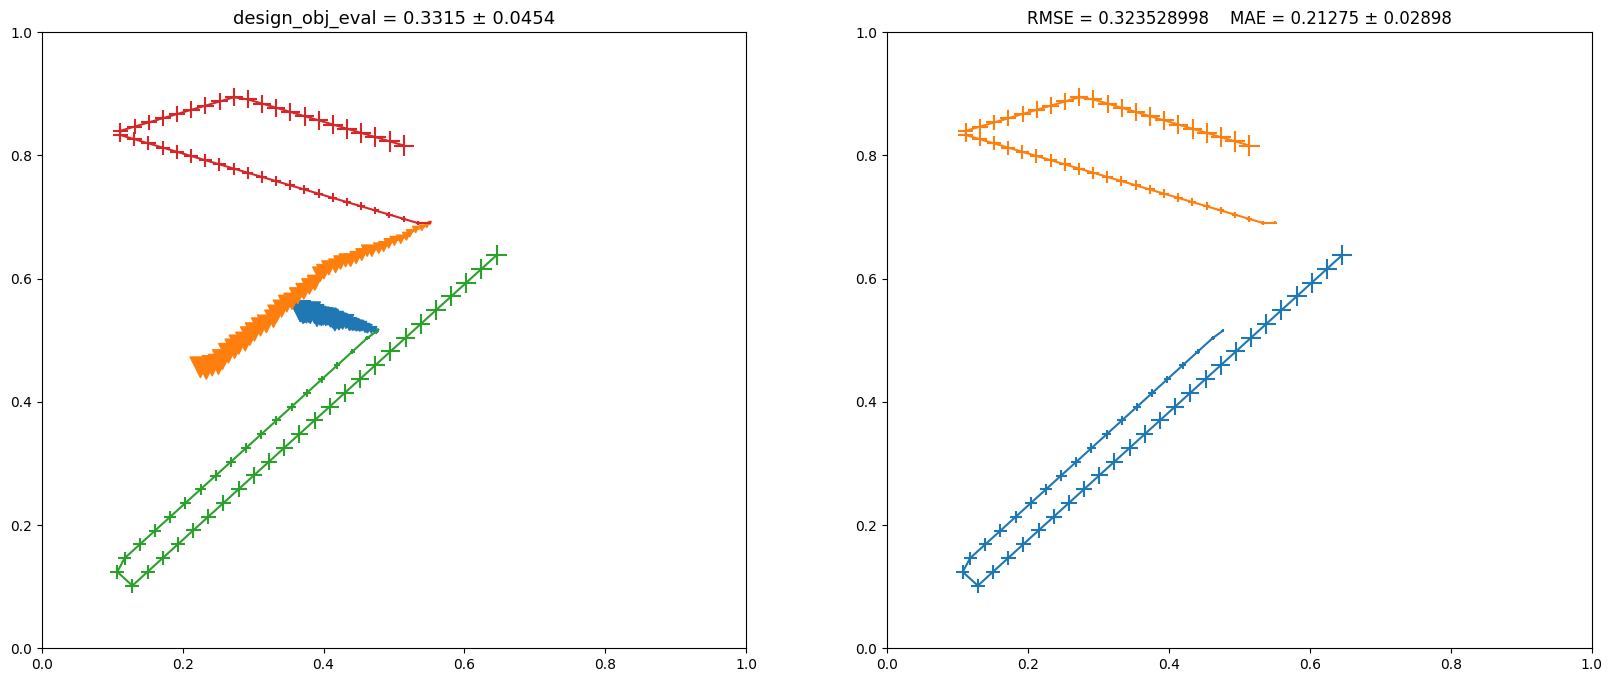

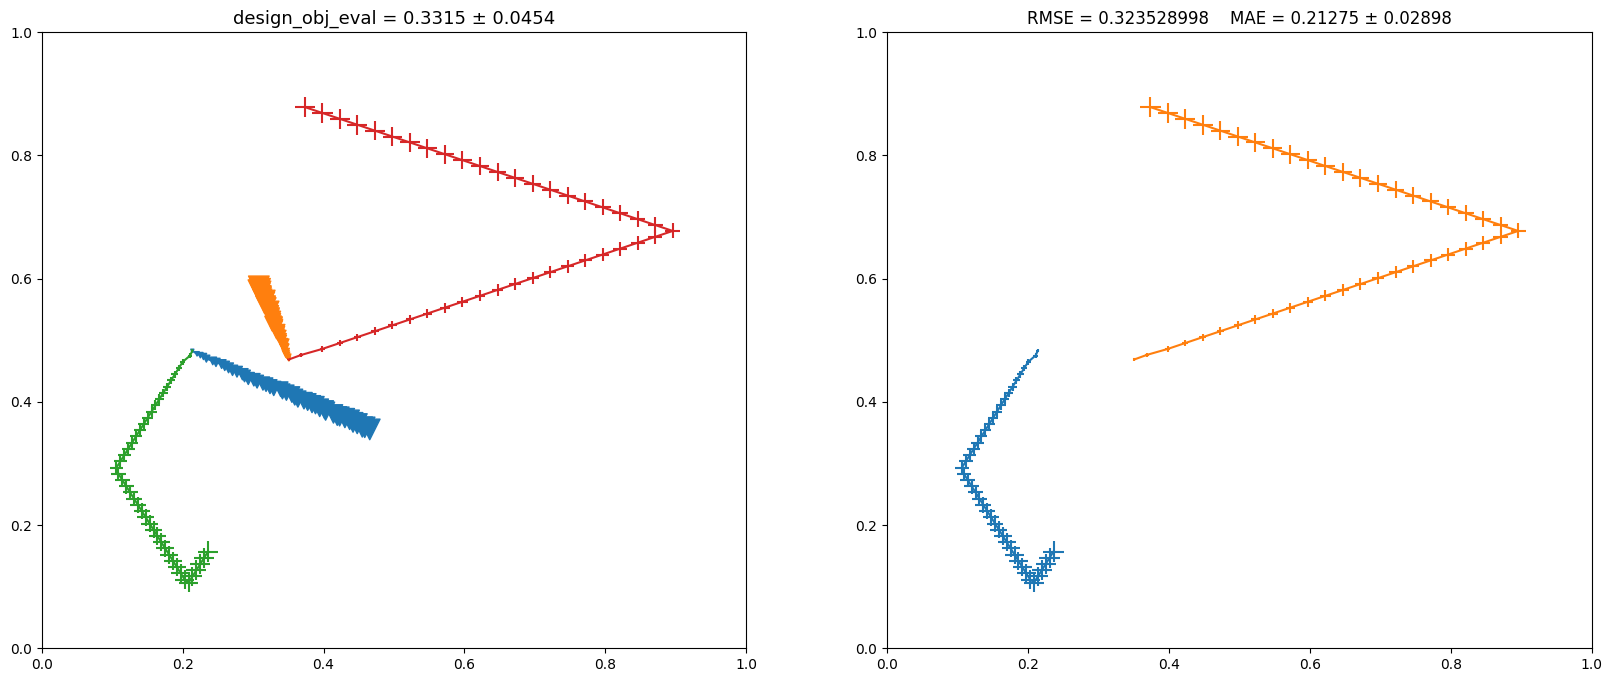

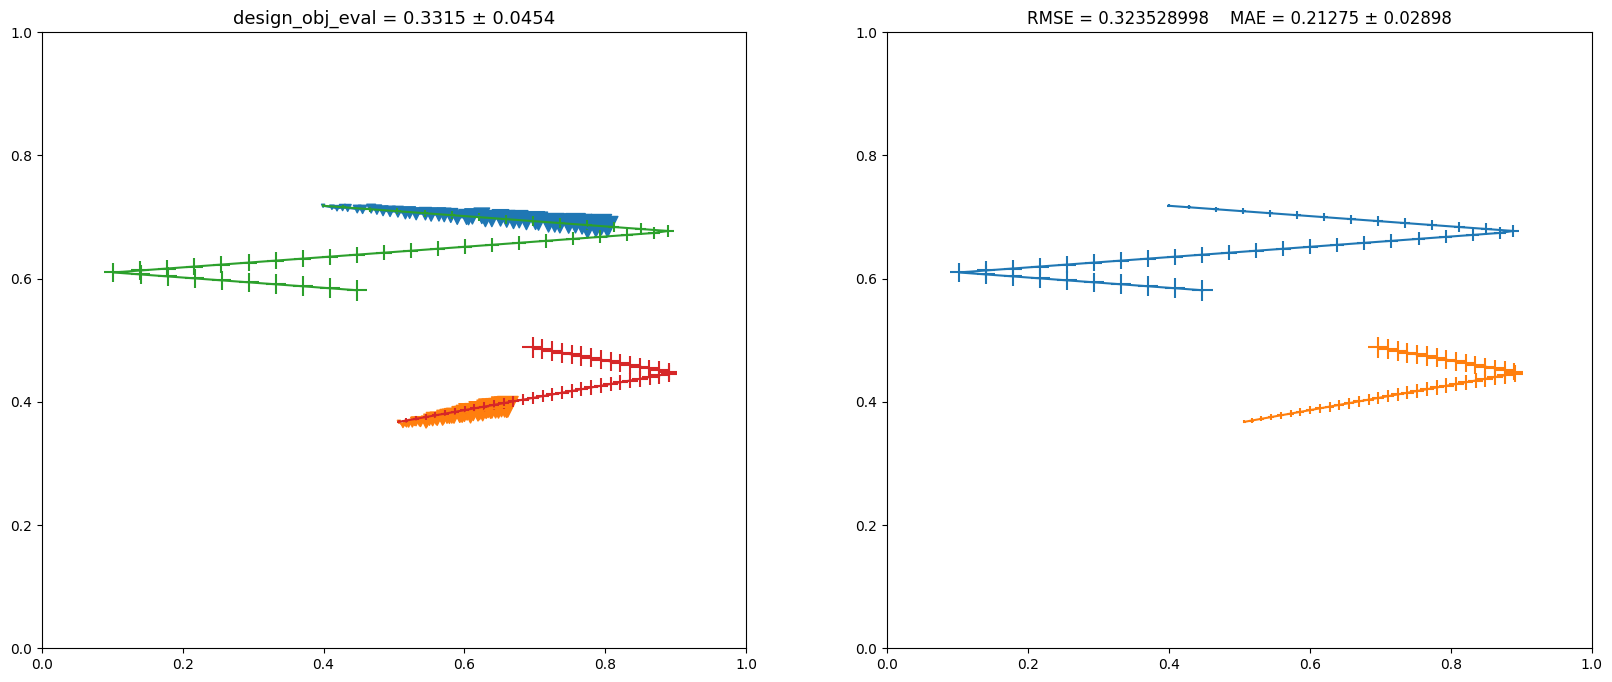

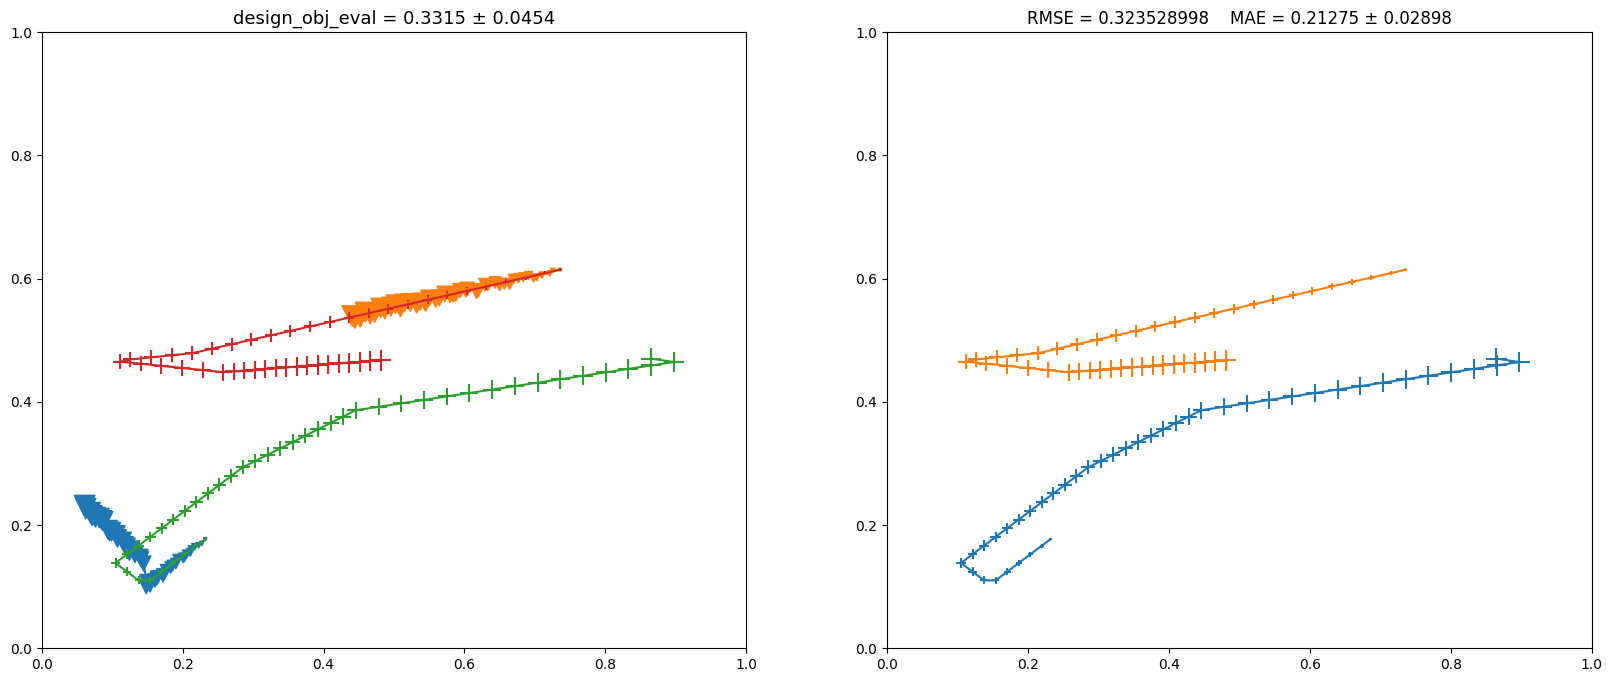

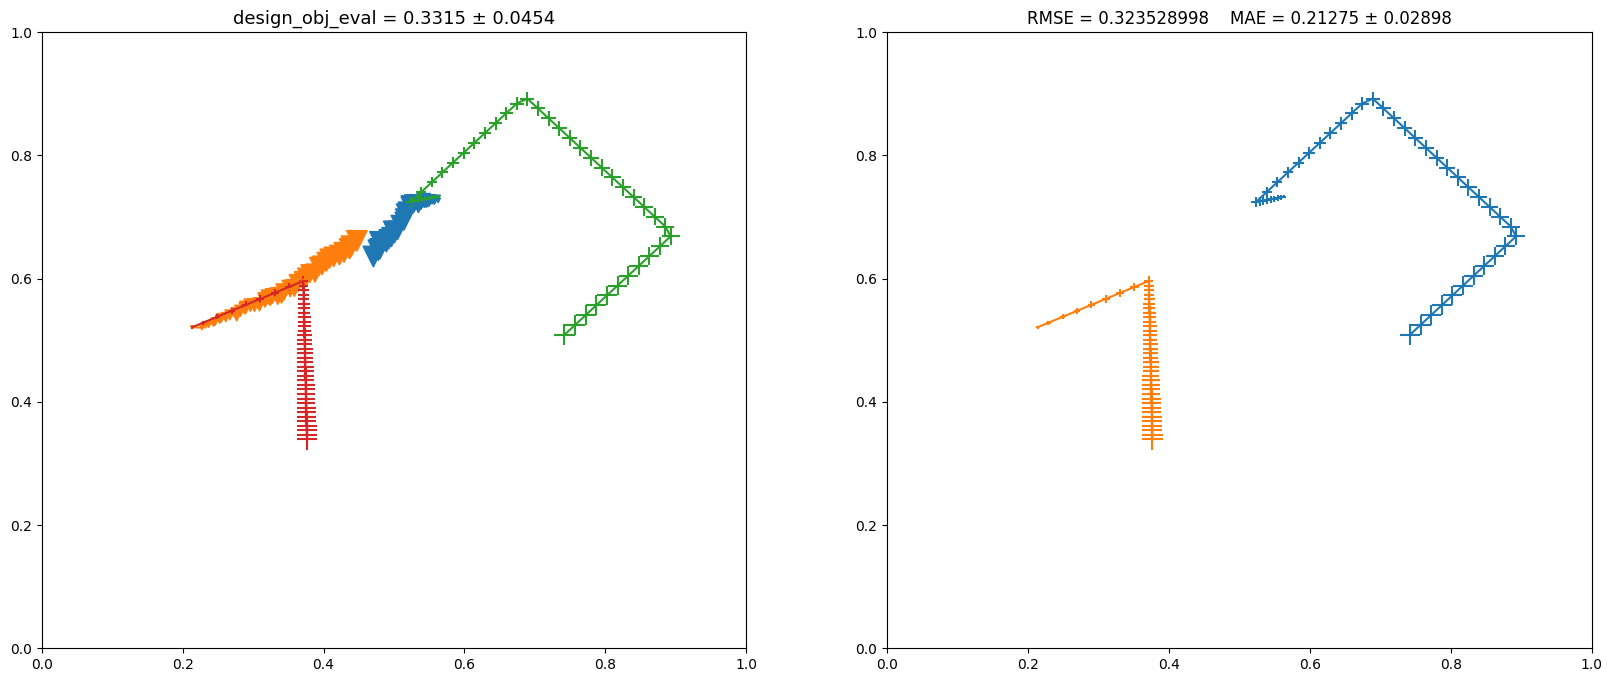

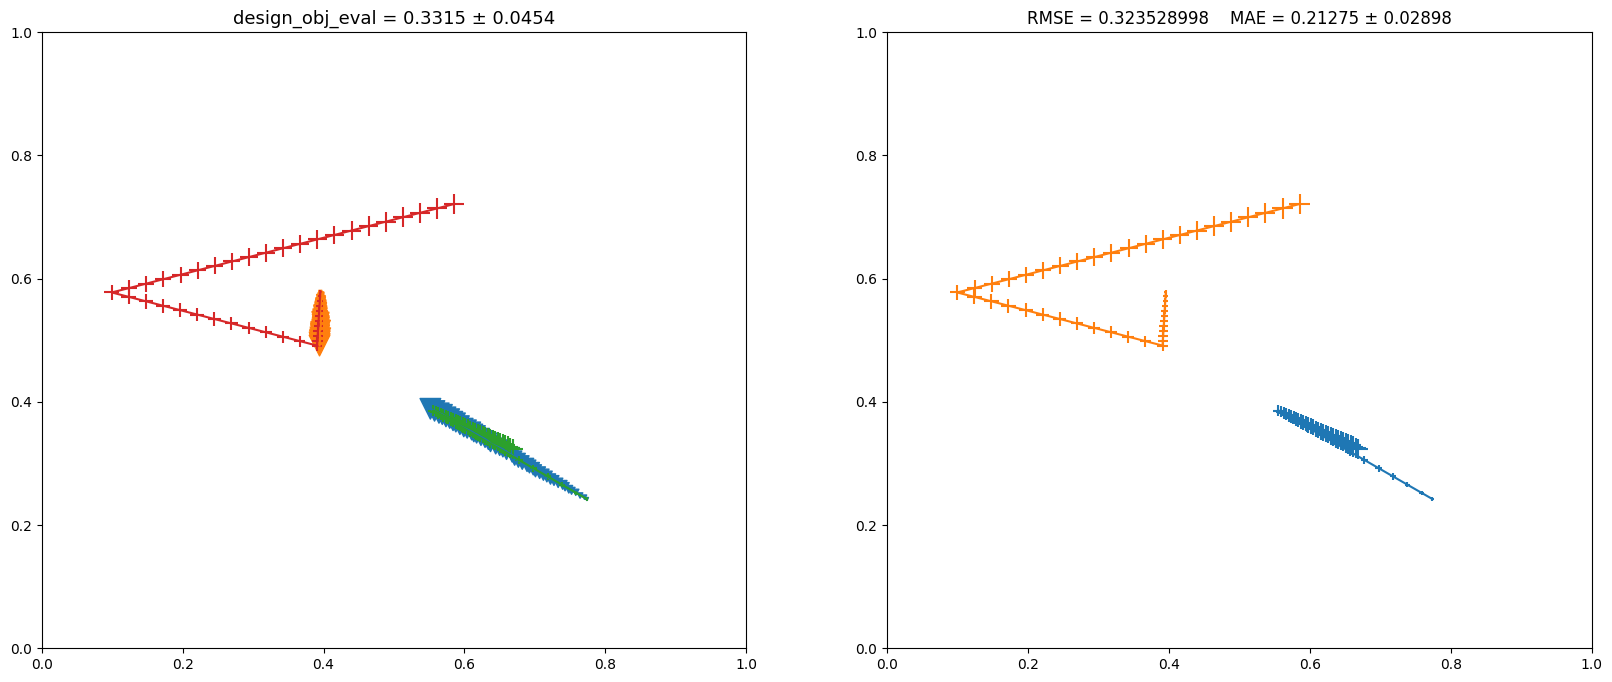

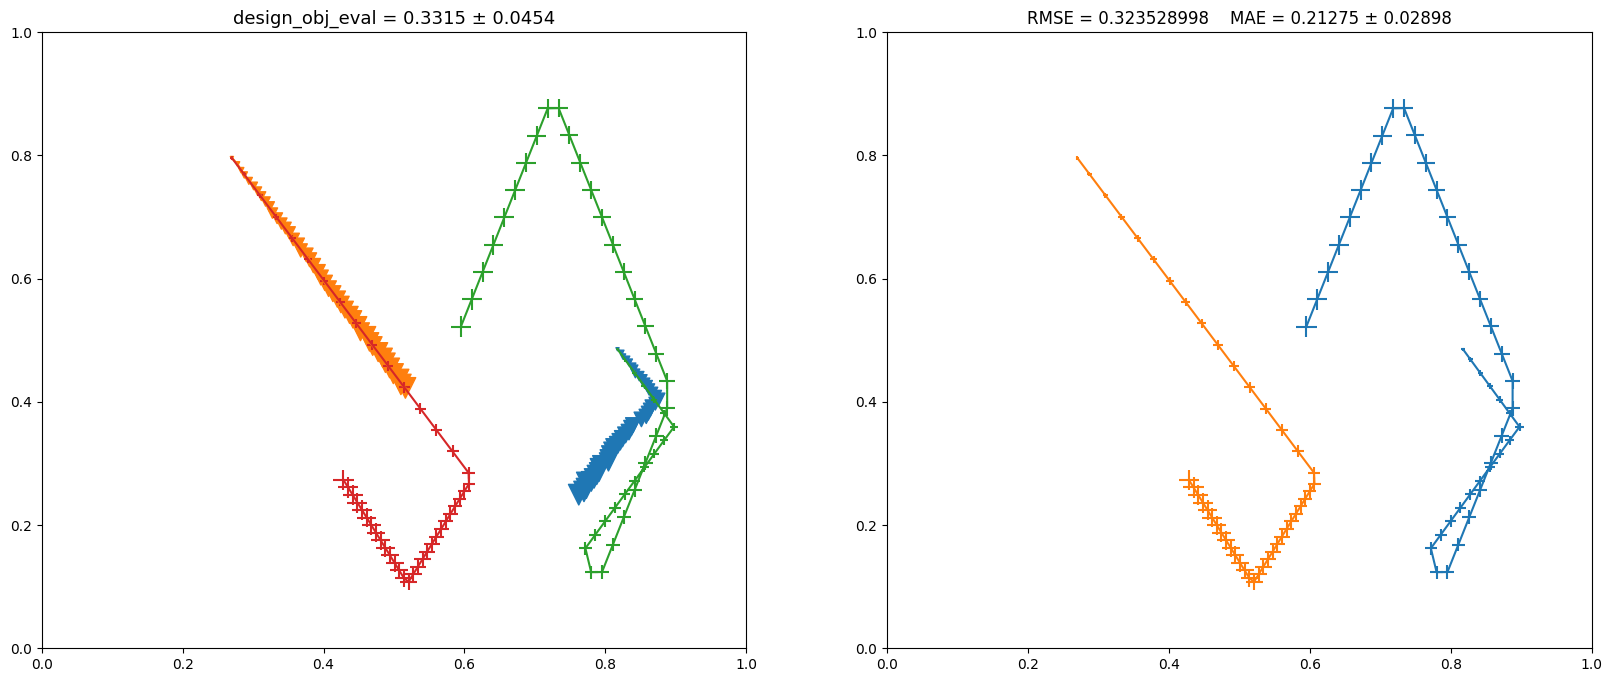

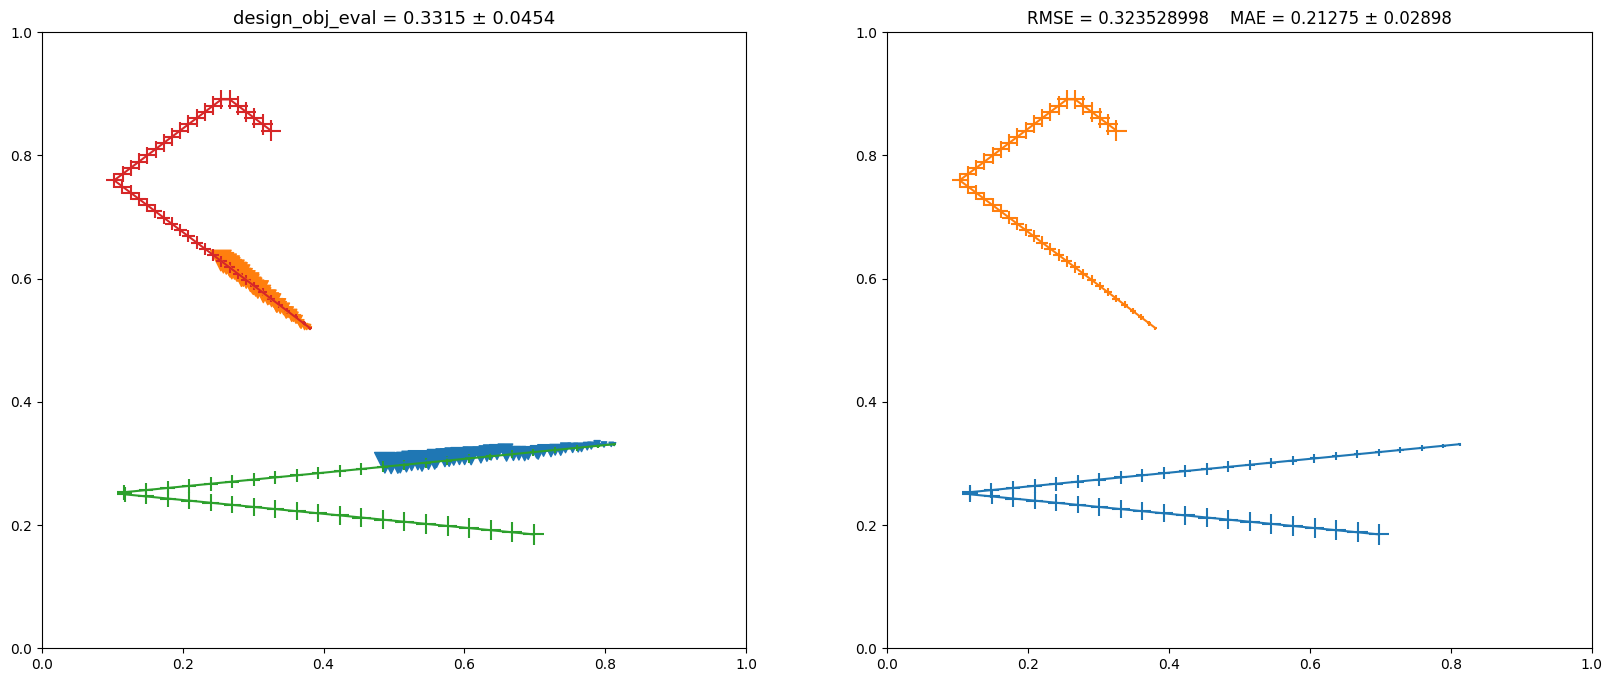

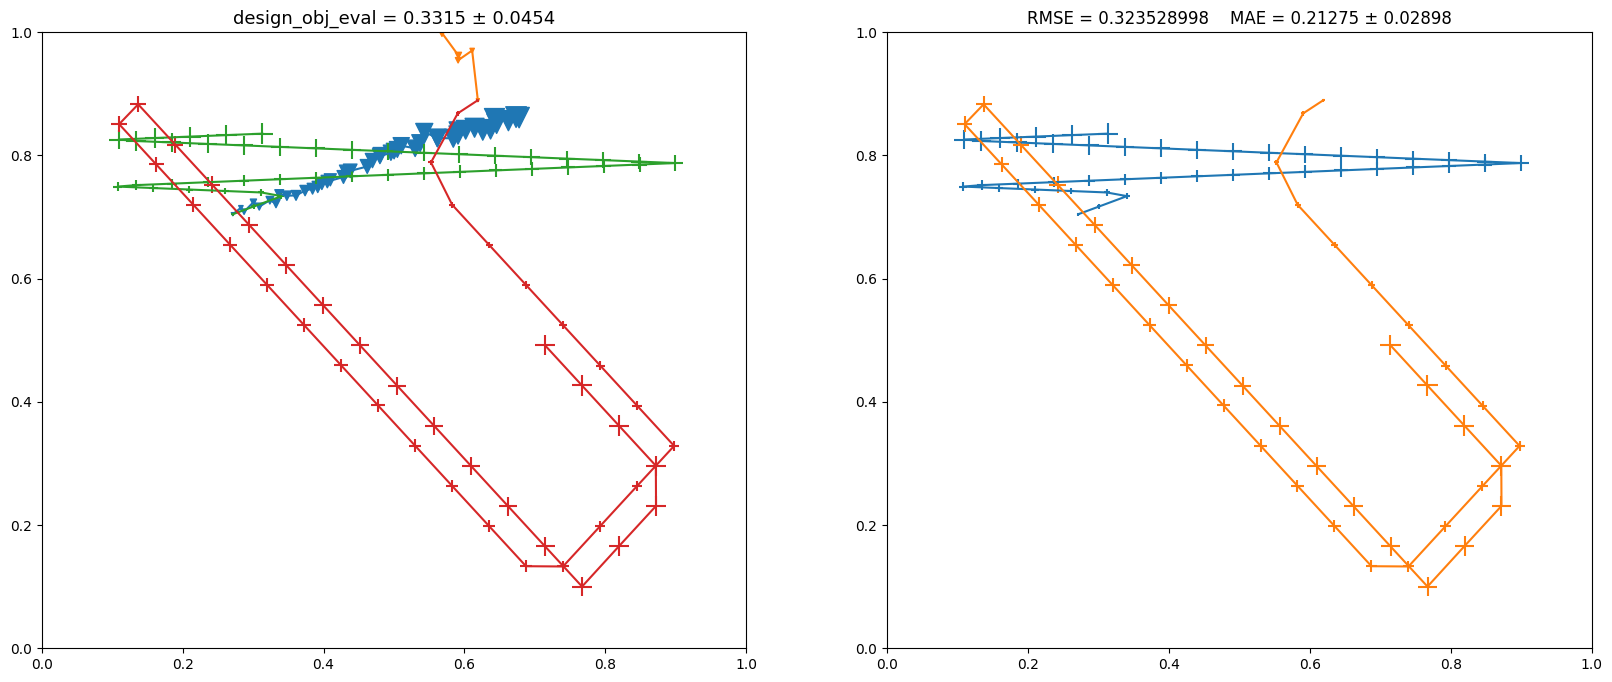

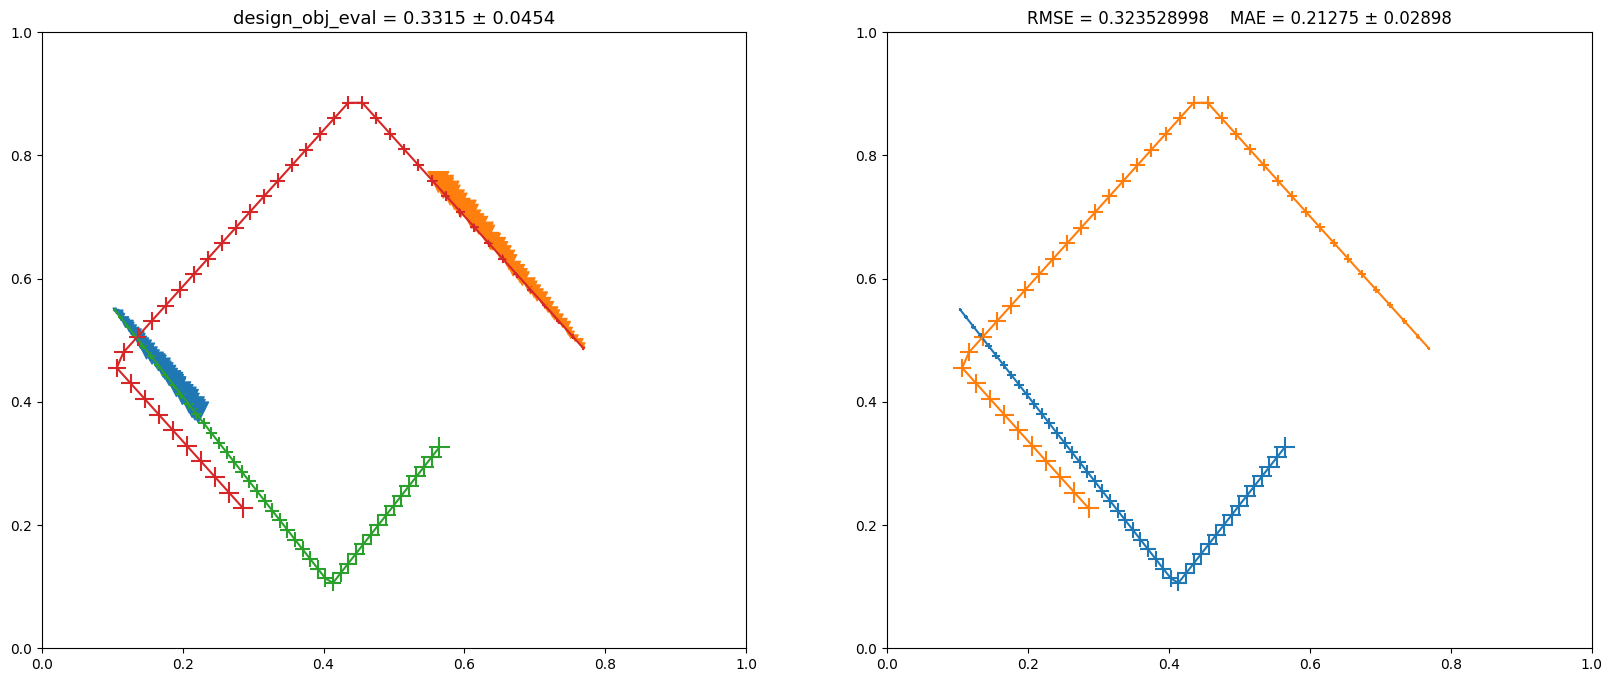

In [5]:
#basic setting
ratio=0.
time_steps=44
file_name="/user/project/inverse_design/results/cINN_1d_inference/test_Xpred_1d_44_20231116_233548_down_ratio_0.0_.npy"
val_batch_size=50
device = torch.device("cuda:0")
pos_target = torch.tensor([0.5,0.5], device=device, dtype=float)
eval_fn = get_eval_fn(pos_target, last_n_step=1)
eval_fn_std = get_eval_fn_std(pos_target, last_n_step=1)
#load design results
x_design=np.load(file_name)
print(x_design.shape)
x_design=x_design.reshape((x_design.shape[0],time_steps,8))
x_design=torch.tensor(x_design,device=device)
p.print(f"test_start ", tabs=0, is_datetime=None, banner_size=0, end=None, avg_window=1, precision="millisecond", is_silent=False)
pred_simu, design_obj_simu = eval_simu(
                        cond_design=x_design[:val_batch_size,0:1],
                        design_fn=eval_fn,
                        n_bodies=2,
                        rollout_steps=time_steps - 1,
                    )
p.print(f"test_end ", tabs=0, is_datetime=None, banner_size=0, end=None, avg_window=1, precision="millisecond", is_silent=False)
design_obj_simu_CI = eval_fn_std(pred_simu) * 1.96 / np.sqrt(val_batch_size)
pred_simu = torch.cat([x_design[:val_batch_size,:1].to(device), pred_simu], 1)
diff = pred_simu - x_design
RMSE = diff.square().mean((1,2)).sqrt().mean()
# 95% confidence interval:
RMSE_CI = diff.square().mean((1,2)).sqrt().std() * 1.96 / np.sqrt(val_batch_size)
MAE = torch.nn.L1Loss()(pred_simu, x_design).item()
MAE_CI = diff.abs().mean((1,2)).std().item() * 1.96 / np.sqrt(val_batch_size)
print(f"design_obj_simu: {design_obj_simu:.6f} ± {design_obj_simu_CI:.6f}", )
print(f"MAE: {MAE} ± {MAE_CI}", )
pdf = matplotlib.backends.backend_pdf.PdfPages(file_name.replace(".npy",".pdf"))
T = pred_simu.shape[1]
for ball_id in range(20):
    fig = plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    # diffused traj:
    for ii in range(2):
        plt.plot(x_design.cpu()[ball_id, :, ii*4], x_design.cpu()[ball_id, :, ii*4+1])
        plt.scatter(x_design.cpu()[ball_id, :, ii*4], x_design.cpu()[ball_id, :, ii*4+1], s=np.arange(1, T+1)*5, marker="v")
    # evolved traj with initial design:
    for ii in range(2):
        plt.plot(pred_simu.cpu()[ball_id, :, ii*4], pred_simu.cpu()[ball_id, :, ii*4+1])
        plt.scatter(pred_simu.cpu()[ball_id, :, ii*4], pred_simu.cpu()[ball_id, :, ii*4+1], s=np.arange(1, T+1)*5, marker="+")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(f"design_obj_eval = {design_obj_simu:.4f} ± {design_obj_simu_CI:.4f}", fontsize=13)
    plt.subplot(1,2,2)
    for ii in range(2):
        plt.plot(pred_simu.cpu()[ball_id, :, ii*4], pred_simu.cpu()[ball_id, :, ii*4+1])
        plt.scatter(pred_simu.cpu()[ball_id, :, ii*4], pred_simu.cpu()[ball_id, :, ii*4+1], s=np.arange(1, T+1)*5, marker="+")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(f"RMSE = {RMSE:.9f}    MAE = {MAE:.5f} ± {MAE_CI:.5f}")
    pdf.savefig(fig)
pdf.close()

In [ ]:
#basic setting
ratio=0.
time_steps=44
file_name="/user/project/inverse_design/results/cINN_1d_inference/test_Xpred_1d_44_20231116_233548_down_ratio_0.0.npy"
val_batch_size=50
device = torch.device("cuda:0")
pos_target = torch.tensor([0.5,0.5], device=device, dtype=float)
eval_fn = get_eval_fn(pos_target, last_n_step=1)
eval_fn_std = get_eval_fn_std(pos_target, last_n_step=1)
#load design results
x_design=np.load(file_name)
print(x_design.shape)
x_design=x_design.reshape((x_design.shape[0],time_steps,8))
x_design=torch.tensor(x_design,device=device)
p.print(f"test_start ", tabs=0, is_datetime=None, banner_size=0, end=None, avg_window=1, precision="millisecond", is_silent=False)
pred_simu, design_obj_simu = eval_simu(
                        cond_design=x_design[:val_batch_size,0:1],
                        design_fn=eval_fn,
                        n_bodies=2,
                        rollout_steps=time_steps - 1,
                    )
p.print(f"test_end ", tabs=0, is_datetime=None, banner_size=0, end=None, avg_window=1, precision="millisecond", is_silent=False)
design_obj_simu_CI = eval_fn_std(pred_simu) * 1.96 / np.sqrt(val_batch_size)
pred_simu = torch.cat([x_design[:val_batch_size,:1].to(device), pred_simu], 1)
diff = pred_simu - x_design
RMSE = diff.square().mean((1,2)).sqrt().mean()
# 95% confidence interval:
RMSE_CI = diff.square().mean((1,2)).sqrt().std() * 1.96 / np.sqrt(val_batch_size)
MAE = torch.nn.L1Loss()(pred_simu, x_design).item()
MAE_CI = diff.abs().mean((1,2)).std().item() * 1.96 / np.sqrt(val_batch_size)
print(f"design_obj_simu: {design_obj_simu:.6f} ± {design_obj_simu_CI:.6f}", )
print(f"MAE: {MAE} ± {MAE_CI}", )
pdf = matplotlib.backends.backend_pdf.PdfPages(file_name.replace(".npy",".pdf"))
T = pred_simu.shape[1]
for ball_id in range(20):
    fig = plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    # diffused traj:
    for ii in range(2):
        plt.plot(x_design.cpu()[ball_id, :, ii*4], x_design.cpu()[ball_id, :, ii*4+1])
        plt.scatter(x_design.cpu()[ball_id, :, ii*4], x_design.cpu()[ball_id, :, ii*4+1], s=np.arange(1, T+1)*5, marker="v")
    # evolved traj with initial design:
    for ii in range(2):
        plt.plot(pred_simu.cpu()[ball_id, :, ii*4], pred_simu.cpu()[ball_id, :, ii*4+1])
        plt.scatter(pred_simu.cpu()[ball_id, :, ii*4], pred_simu.cpu()[ball_id, :, ii*4+1], s=np.arange(1, T+1)*5, marker="+")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(f"design_obj_eval = {design_obj_simu:.4f} ± {design_obj_simu_CI:.4f}", fontsize=13)
    plt.subplot(1,2,2)
    for ii in range(2):
        plt.plot(pred_simu.cpu()[ball_id, :, ii*4], pred_simu.cpu()[ball_id, :, ii*4+1])
        plt.scatter(pred_simu.cpu()[ball_id, :, ii*4], pred_simu.cpu()[ball_id, :, ii*4+1], s=np.arange(1, T+1)*5, marker="+")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(f"RMSE = {RMSE:.9f}    MAE = {MAE:.5f} ± {MAE_CI:.5f}")
    pdf.savefig(fig)
pdf.close()

(50, 352)
[2023-11-17 09:20:23.850580] test_start    	2269.376443s from last print, 1-step avg: 2269.376443s


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM default


  0%|          | 0/50 [00:00<?, ?it/s]